# A/B тестирование

## Постановка задачи.

**Задача** — провести оценку результатов A/B-теста. В вашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

- Оцените корректность проведения теста
- Проанализируйте результаты теста

Чтобы оценить корректность проведения теста, проверьте:

- пересечение тестовой аудитории с конкурирующим тестом,
- совпадение теста и маркетинговых событий, другие проблемы временных границ теста.

## Техническое задание.

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

## Данные и их описание.

Нам даны 4 данных.

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

`final_ab_participants.csv` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

## Загрузка данных и изучение общей информации.

In [1]:
#Загрузим библиотеки, которые понадобятся

import pandas as pd
import numpy as np
import math as mth
from scipy import stats as st
import matplotlib.pyplot as plt 
import matplotlib as mpl
from plotly.subplots import make_subplots
import plotly.express as px
from plotly import graph_objects as go
import seaborn as sns 
from numpy import median
from datetime import datetime, timedelta
%pip install -U kaleido -q
import plotly.io as pio
pio.renderers.default = "png"

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
pth1 = '/Users/alexbay/Desktop/Финальный АВ проект/'
pth2 = '/datasets/'
if os.path.exists(pth1):
    events = pd.read_csv(pth1 + 'final_ab_events.csv')
    marketing_events = pd.read_csv(pth1 + 'ab_project_marketing_events.csv')
    users = pd.read_csv(pth1 + 'final_ab_new_users.csv')
    participants = pd.read_csv(pth1 + 'final_ab_participants.csv')
elif os.path.exists(pth2):
    events = pd.read_csv(pth2 + 'final_ab_events.csv')
    marketing_events = pd.read_csv(pth2 + 'ab_project_marketing_events.csv')
    users = pd.read_csv(pth2 + 'final_ab_new_users.csv')
    participants = pd.read_csv(pth2 + 'final_ab_participants.csv')
else:
    print('Something is wrong') 

### Изучаем данные

**Смотрим датасет "events"**. Действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

In [3]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


Нужно поменять тип в столбце "event_dt"

In [4]:
events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [5]:
events.isna().sum()

user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

In [6]:
events.isna().sum()*100/len(events)

user_id        0.000000
event_dt       0.000000
event_name     0.000000
details       85.751175
dtype: float64

Пропуски есть в столбце "details" их 85.75%

In [7]:
for row in events:
    print(events[row].value_counts())

A3917F81482141F2    36
D6477068EF132236    32
8AEB716C4CD82CA7    32
590DACD07A839BC3    32
3356239C0DC75E2A    32
                    ..
B80297D6570EA5FE     1
D2656A48DD3C4EEE     1
83E9CFC64D61108E     1
30C9930817226A34     1
F7DC611E716A9F76     1
Name: user_id, Length: 58703, dtype: int64
2020-12-23 02:37:24    10
2020-12-14 18:54:55    10
2020-12-20 02:51:18     9
2020-12-24 00:54:52     9
2020-12-13 06:00:54     9
                       ..
2020-12-18 10:54:12     1
2020-12-18 19:31:57     1
2020-12-18 09:04:49     1
2020-12-18 16:53:52     1
2020-12-30 10:59:09     1
Name: event_dt, Length: 267268, dtype: int64
login           189552
product_page    125563
purchase         62740
product_cart     62462
Name: event_name, dtype: int64
4.99      46362
9.99       9530
99.99      5631
499.99     1217
Name: details, dtype: int64


Самый активный пользователь - "A3917F81482141F2". У него 36 действий. Больше всего активности в 14 и 23 декабря, по 10. В типах больше всего "login" 189552 действий. В дополнительных данных больше всего действий у "4.99" - 46362, видимо это какая-то цена.

In [8]:
events.duplicated().sum()

0

Дубликатов нет.

In [9]:
events.describe().T

,count,mean,std,min,25%,50%,75%,max
details,62740.0,23.877631,72.180465,4.99,4.99,4.99,9.99,499.99


В столбце "details" максимальное значение 499.99 а минимальное значение 4.99. Значит пользователей покупали больше всего самый дешевый товар.

**Смотрим датасет "marketing_events".** календарь маркетинговых событий на 2020 год.

In [10]:
marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


Нужно поменять тип в столбцах "start_dt" и "finish_dt".

In [11]:
marketing_events.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [12]:
marketing_events.isna().sum()

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

Пропусков нет.

In [13]:
for row in marketing_events:
    print(marketing_events[row].value_counts())

Christmas&New Year Promo            1
St. Valentine's Day Giveaway        1
St. Patric's Day Promo              1
Easter Promo                        1
4th of July Promo                   1
Black Friday Ads Campaign           1
Chinese New Year Promo              1
Labor day (May 1st) Ads Campaign    1
International Women's Day Promo     1
Victory Day CIS (May 9th) Event     1
CIS New Year Gift Lottery           1
Dragon Boat Festival Giveaway       1
Single's Day Gift Promo             1
Chinese Moon Festival               1
Name: name, dtype: int64
APAC                        4
EU, CIS, APAC, N.America    3
EU, N.America               2
EU, CIS, APAC               2
CIS                         2
N.America                   1
Name: regions, dtype: int64
2020-12-25    1
2020-02-14    1
2020-03-17    1
2020-04-12    1
2020-07-04    1
2020-11-26    1
2020-01-25    1
2020-05-01    1
2020-03-08    1
2020-05-09    1
2020-12-30    1
2020-06-25    1
2020-11-11    1
2020-10-01    1
Name: start

Регион, в котором будет больше всего проводиться рекламных кампаний это APAC.

In [14]:
marketing_events.duplicated().sum()

0

Дубликатов нет.

**Смотрим на датасет "users"**. пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

In [15]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


Нужно поменять тип в колонке "first_date".

In [16]:
users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [17]:
users.isna().sum()

user_id       0
first_date    0
region        0
device        0
dtype: int64

Пропусков нет.

In [18]:
for row in users:
    print(users[row].value_counts())

D72A72121175D8BE    1
A25EF6D0E025C48E    1
62B9FD1B8BDB669C    1
9A5F371EED469627    1
2DF6B79FC97641EC    1
                   ..
133FDC1180FC743E    1
35F8FFAF240FDB9B    1
C7AAF024F4FF63C5    1
A6EA45CB9FBAB213    1
8F04273BB2860229    1
Name: user_id, Length: 61733, dtype: int64
2020-12-21    6290
2020-12-14    5654
2020-12-07    5595
2020-12-13    4691
2020-12-20    4288
2020-12-12    3963
2020-12-19    3617
2020-12-18    3365
2020-12-08    3239
2020-12-22    3083
2020-12-10    3076
2020-12-17    3048
2020-12-15    3043
2020-12-11    2390
2020-12-23    2180
2020-12-16    2110
2020-12-09    2101
Name: first_date, dtype: int64
EU           46270
N.America     9155
CIS           3155
APAC          3153
Name: region, dtype: int64
Android    27520
PC         15599
iPhone     12530
Mac         6084
Name: device, dtype: int64


Новые пользователи больше всего регистрировались 21 декабря 2020года. Большинство новых пользователей их региона EU. И у большинства новых пользователей девайс Android.

In [19]:
users.duplicated().sum()

0

Дубликатов нет.

**Смотрим на датасет "participants"**. таблица участников тестов.

In [20]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


In [21]:
participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [22]:
participants.isna().sum()

user_id    0
group      0
ab_test    0
dtype: int64

Пропусков нет.

In [23]:
for row in participants:
    print(participants[row].value_counts())

0FDFDA0B2DEC2D91    2
00E68F103C66C1F7    2
BD23AF6242CA944B    2
DD670F7422342729    2
A5E27D8BCACA668E    2
                   ..
A1591805E7D020EE    1
400D3BD0BCB31971    1
D2656A48DD3C4EEE    1
953E74FDE41424B4    1
79F9ABFB029CF724    1
Name: user_id, Length: 16666, dtype: int64
A    9655
B    8613
Name: group, dtype: int64
interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64


В тестировании 2 группы: А(9655) и В(8613). И 2 теста: interface_eu_test (11567), recommender_system_test (6701).

In [24]:
participants.duplicated().sum()

0

Дубликатов нет.

### Предобработка данных.

Посмотрим детально на пропуски в датасете events, колонки details, к каким событиям они соответствуют.

In [25]:
events['event_name'].unique()

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

In [26]:
events[events['event_name']=='purchase'].isna().sum()

user_id       0
event_dt      0
event_name    0
details       0
dtype: int64

In [27]:
events[events['event_name']=='product_cart'].isna().sum()

user_id           0
event_dt          0
event_name        0
details       62462
dtype: int64

In [28]:
events[events['event_name']=='product_page'].isna().sum()

user_id            0
event_dt           0
event_name         0
details       125563
dtype: int64

In [29]:
events[events['event_name']=='login'].isna().sum()

user_id            0
event_dt           0
event_name         0
details       189552
dtype: int64

Наличие пропусков может быть обусловлена отсутствием необходимости указания данной информации, например, в разрезе событий purchase в колонке details отсутствуют пропуски, т.к. по заданию в ней отображается стоимость покупки в долларах. Оставим пропуски как есть.

Преобразуем нужные столбцы в нужные типы.

In [30]:
marketing_events['start_dt'] = marketing_events['start_dt'].astype('datetime64')
marketing_events['finish_dt'] = marketing_events['finish_dt'].astype('datetime64')
users['first_date'] = users['first_date'].astype('datetime64')
events['event_dt'] = events['event_dt'].astype('datetime64')

### Оценим корректность теста (техническое задание).

#### Проверим название теста.

In [31]:
participants['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

Название теста соответствует.

#### Группы: А (контрольная), B (новая платёжная воронка).

In [32]:
participants[['ab_test', 'group']].groupby('ab_test').agg({'group':'unique'})

,group
ab_test,
interface_eu_test,"[A, B]"
recommender_system_test,"[A, B]"


Группы тоже соответствуют.

#### Дата запуска: 2020-12-07.

In [33]:
users['first_date'].min()

Timestamp('2020-12-07 00:00:00')

Дата запуска тоже соответствует.

####  Дата остановки набора новых пользователей: 2020-12-21.

In [34]:
stop_date = users.merge(participants, on='user_id', how='left')
stop_date = stop_date[stop_date['ab_test']=='recommender_system_test']
stop_date['first_date'].max()

Timestamp('2020-12-21 00:00:00')

Дата остановки набора новых пользователей тоже соответствует.

#### Дата остановки: 2021-01-04.

In [35]:
events['event_dt'].max()

Timestamp('2020-12-30 23:36:33')

А вот дата остановки не соответствует тех. заданию.

#### Аудитория: 15% новых пользователей из региона EU.

In [36]:
start_users = users['first_date'].min()
final_users = users['first_date'].max()
start_test = pd.to_datetime('2020-12-07') #запуск теста

Найдем новых пользователей из датасета participants, которые участвовали в А/Б тесте по рекоммендательной системе. Потом найдем их в датасете users.

In [37]:
participants_users = participants[participants['ab_test']=='recommender_system_test']['user_id']
users_test = users[users['user_id'].isin(participants_users)]
new_users = users_test[(users_test['region'] == 'EU')].shape[0]

Посчитаем, сколько пользователей из набранных, являются пользователями региона EU.

In [38]:
eu_users = users_test[(users_test['region'] == 'EU')]

eu_users = users[(users['region'] == 'EU') &
                 (users['first_date'] >= start_test) &
                 (users['first_date'] <= start_test + timedelta(14))]
all_users = eu_users.shape[0]

In [39]:
round(new_users/all_users*100,2)

15.0

Аудитория: 15% новых пользователей из региона EU. Соответствует тех.заданию.

#### Ожидаемое количество участников теста: 6000.

In [40]:
events_users = events[events['user_id'].isin(participants_users)]
events_users['user_id'].nunique()

3675

Ожидаемое количество участников теста значительно ниже.

### Исследовательский анализ данных.

#### Проверим, есть ли в данных события старше 14 дней с момента регистрации у пользователей.

In [41]:
users['time_test'] = users['first_date']+timedelta(15)

In [42]:
events = events.merge(users, on='user_id', how='left')

Создали новый столбец, в котором записали дату 14-го дня с момента регистрации. Соединили датасеты events и users.

Создадим функцию, которая сравнивает дату события с конечной датой временного периода. И создадим столбец date_status в датасете events.

In [43]:
def events_time (row):
    if row.event_dt > row.time_test:
        return 'Событие выходит за рассматриваемый период'
    else:
        return 'Событие в рамках рассматриваемого периода'

In [44]:
events['date_status'] = events.apply(events_time, axis=1)
events.head()

,user_id,event_dt,event_name,details,first_date,region,device,time_test,date_status
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,2020-12-07,N.America,iPhone,2020-12-22,Событие в рамках рассматриваемого периода
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,2020-12-07,EU,iPhone,2020-12-22,Событие в рамках рассматриваемого периода
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99,2020-12-07,N.America,iPhone,2020-12-22,Событие в рамках рассматриваемого периода
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07,EU,iPhone,2020-12-22,Событие в рамках рассматриваемого периода
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,2020-12-07,EU,Android,2020-12-22,Событие в рамках рассматриваемого периода


In [45]:
events['date_status'].value_counts()

Событие в рамках рассматриваемого периода    424907
Событие выходит за рассматриваемый период     15410
Name: date_status, dtype: int64

15 410 событий выходят за рамки рассматриваемого периода. Отфильтруем и оставим события в рамках рассматриваемого периода.

In [46]:
events = events[events['date_status']!='Событие выходит за рассматриваемый период']
events['date_status'].value_counts()

Событие в рамках рассматриваемого периода    424907
Name: date_status, dtype: int64

#### Изучим аудиторию теста.

Создадим два датасета с участниками в разбивке по видам АБ теста.

In [47]:
recommend_system_test = participants[participants['ab_test']=='recommender_system_test']
interface_eu_test = participants[participants['ab_test']=='interface_eu_test']
interface_eu_test['user_id'].nunique()

11567

Проверим, что нет пересечений пользователей с конкурирующим тестом.

In [48]:
double = interface_eu_test[interface_eu_test['user_id'].isin(recommend_system_test['user_id'])]
double['user_id'].nunique()

1602

In [49]:
round(1602/participants['user_id'].nunique()*100, 2)

9.61

9.61% пользователей попали в оба эксперимента, что очень сильно может исказить результаты теста.

Проверим, что нет пересечений пользователей, участвующих в двух группах теста одновременно.

In [50]:
group_A = recommend_system_test[recommend_system_test['group']=='A']
group_B = recommend_system_test[recommend_system_test['group']=='B']

double_group = group_A[group_A['user_id'].isin(group_B['user_id'])]
double_group['user_id'].nunique()

0

Пользователей, которые попали в обе группы теста recommend_system_test нет.

#### Проверим равномерность распределения пользователей по тестовым группам и правильность их формирования.

In [51]:
events_participants = events.merge(participants[participants['ab_test']=='recommender_system_test'], on='user_id')

events_participants.groupby(
    'group')['user_id'].nunique()

group
A    2747
B     928
Name: user_id, dtype: int64

Мы видим, что кол-во пользователей группы А значительно превышает кол-во пользователей группы В. Это говорит нам о неравномерном распределении пользователей по группам.

#### Изучим, одинаково ли распределены в выборках количество событий на пользователя.

In [52]:
events_count = events_participants.groupby('user_id').agg({'event_name':'count'}).reset_index()
events_count.columns = ['user_id','events_count']
events_count

,user_id,events_count
0,001064FEAAB631A1,6
1,0010A1C096941592,12
2,00341D8401F0F665,2
3,003DF44D7589BBD4,15
4,00505E15A9D81546,5
...,...,...
3670,FF5B24BCE4387F86,9
3671,FF825C1D791989B5,8
3672,FF8CF7057415EB29,4
3673,FFAE9489C76F352B,6


In [53]:
# присоединим к таблице с кол-ом событий виды групп из таблицы recommend_system_test
events_count =  events_count.merge(recommend_system_test, how='left', on='user_id')
events_count

,user_id,events_count,group,ab_test
0,001064FEAAB631A1,6,B,recommender_system_test
1,0010A1C096941592,12,A,recommender_system_test
2,00341D8401F0F665,2,A,recommender_system_test
3,003DF44D7589BBD4,15,A,recommender_system_test
4,00505E15A9D81546,5,A,recommender_system_test
...,...,...,...,...
3670,FF5B24BCE4387F86,9,A,recommender_system_test
3671,FF825C1D791989B5,8,A,recommender_system_test
3672,FF8CF7057415EB29,4,B,recommender_system_test
3673,FFAE9489C76F352B,6,A,recommender_system_test


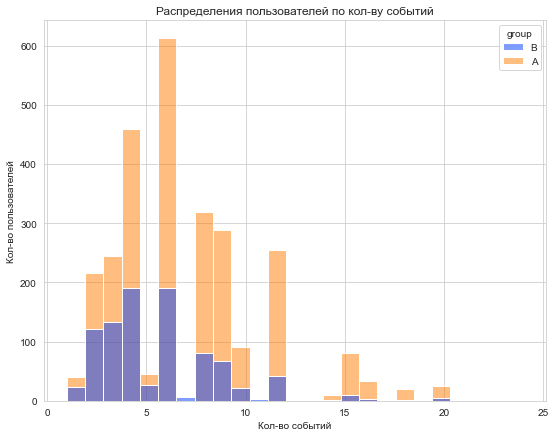

In [54]:
#построим гистограммы распределения пользователей по кол-ву событий в разрезе групп
plt.figure(figsize=(9,7))

sns.set_palette('bright') 
sns.set_style("whitegrid")

sns.histplot(data=events_count, x='events_count', hue='group', bins=25)

plt.xlabel('Кол-во событий')
plt.ylabel('Кол-во пользователей')
plt.title('Распределения пользователей по кол-ву событий')
plt.show()

Посмотрим, все ли пользователи, зарегистрированные в тесте, совершали за период проведения теста события. 

In [55]:
events_count['events_count'].unique()

array([ 6, 12,  2, 15,  5,  4, 20,  9,  8,  3,  1, 10,  7, 16, 24, 18, 11,
       14, 21, 13, 19])

Все пользователи совершали события.

#### Посмотрим, как число событий в выборках распределено по дням.

In [56]:
#преобразуем данные в колонке event_dt в даты без указания времени

events_participants['event_dt'] = pd.to_datetime(events_participants['event_dt'] ).dt.date

events_participants_1=events_participants.sort_values(by='group', ascending=False)

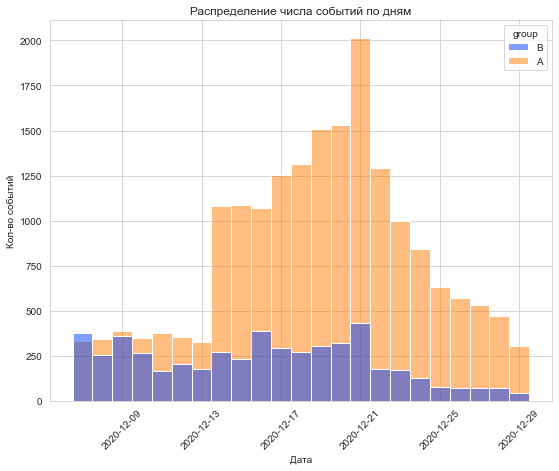

In [57]:
plt.figure(figsize=(9,7))

sns.set_palette('bright') 
sns.set_style("whitegrid")

sns.histplot(data=events_participants_1, x='event_dt', hue='group')


plt.xticks(rotation=45)

plt.xlabel('Дата')
plt.ylabel('Кол-во событий')
plt.title('Распределение числа событий по дням')
plt.show()

По гистограмме распределения мы видим, что число событий практически по всем дням меньше в группе В. Особенно с 14го по 24го декабря намного большая разница.

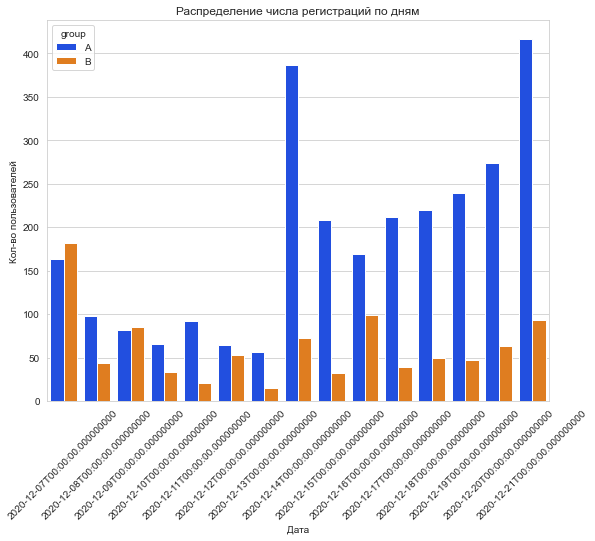

In [58]:
tmp = events_participants.groupby(['group','first_date']).agg({'user_id':'nunique'}).reset_index()

plt.figure(figsize=(9,7))

sns.set_palette('bright') 
sns.set_style("whitegrid")

sns.barplot(data=tmp, x='first_date', y='user_id', hue='group')


plt.xticks(rotation=45)

plt.xlabel('Дата')
plt.ylabel('Кол-во пользователей')
plt.title('Распределение числа регистраций по дням')
plt.show()

С 14 числа в группе А пошел резкий скачек набора пользователей, в группе В - такого не было. При корректной работе системы распределения пользователей, пользователи в две группы должны набираться примерно в равном соотношении. Поэтому, с 14 числа увеличилось количество событий в группе А. 

#### Проанализируем, как меняется конверсия в воронке в выборках на разных этапах?

In [59]:
# сгруппируем данные по группе A и названию события, посчиатем кол-во уникальных пользователей по этим событиям
df_funnel_A = events_participants[events_participants['group']=='A']

df_funnel_A.loc[df_funnel_A['event_name']=='product_cart', 'event_name'] = 'products_cart'

df_funnel_A = df_funnel_A.groupby(['group','event_name']).agg({'user_id':'nunique'}).sort_values(
    by = 'event_name').reset_index()
df_funnel_A

,group,event_name,user_id
0,A,login,2747
1,A,product_page,1780
2,A,products_cart,824
3,A,purchase,872


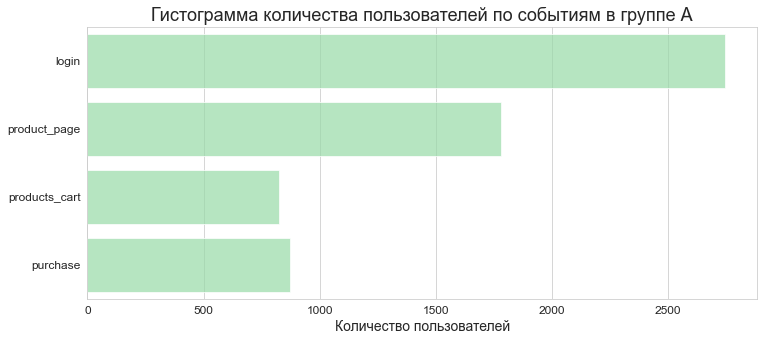

In [60]:
fig = plt.figure(figsize=(12, 5))
sns.set_color_codes('pastel')
splot_na = sns.barplot(y='event_name', x='user_id', data=df_funnel_A , alpha = 0.7, color='g')

plt.title('Гистограмма количества пользователей по событиям в группе А', fontsize=(18))
plt.xlabel('', fontsize=(12))
#plt.legend(frameon=True,loc="upper right",fontsize = 10)
plt.ylabel('', fontsize=(12))
plt.xticks(fontsize=(12))
plt.yticks(fontsize=(12))
plt.xlabel('Количество пользователей', size=(14))
plt.show()

In [61]:
# сгруппируем данные по группе B и названию события, посчиатем кол-во уникальных пользователей по этим событиям
df_funnel_B = events_participants[events_participants['group']=='B']
df_funnel_B.loc[df_funnel_B['event_name']=='product_cart', 'event_name'] = 'products_cart'
df_funnel_B = df_funnel_B.groupby(['group','event_name']).agg({'user_id':'nunique'}).sort_values(
    by = 'event_name').reset_index()
df_funnel_B

,group,event_name,user_id
0,B,login,927
1,B,product_page,523
2,B,products_cart,255
3,B,purchase,256


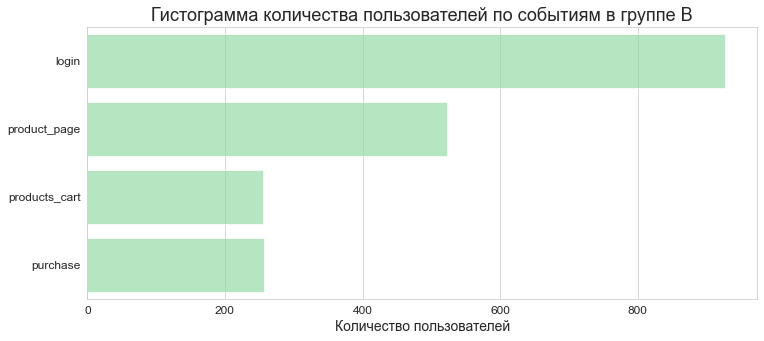

In [62]:
fig = plt.figure(figsize=(12, 5))
sns.set_color_codes('pastel')
splot_na = sns.barplot(y='event_name', x='user_id', data=df_funnel_B , alpha = 0.7, color='g')

plt.title('Гистограмма количества пользователей по событиям в группе B', fontsize=(18))
plt.xlabel('', fontsize=(12))
#plt.legend(frameon=True,loc="upper right",fontsize = 10)
plt.ylabel('', fontsize=(12))
plt.xticks(fontsize=(12))
plt.yticks(fontsize=(12))
plt.xlabel('Количество пользователей', size=(14))
plt.show()

Мы видим, что события подразделяются на 4 основных этапа:

- login (авторизация),
- product_page (просмотр карточки товара),
- purchase (покупка)
- product_cart (просмотр корзины)

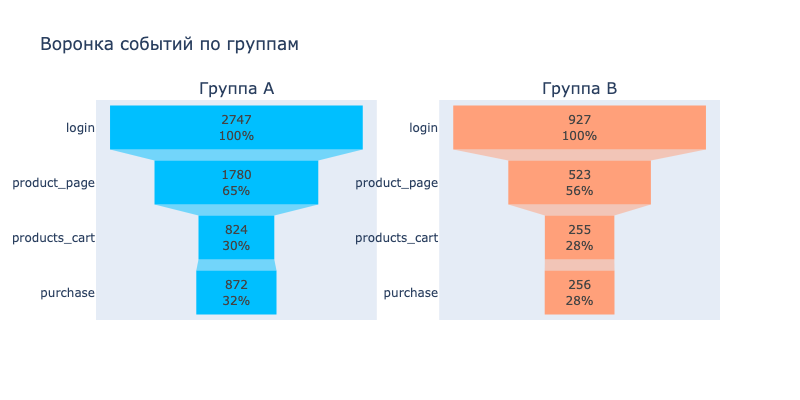

In [63]:
#построим воронку событий по каждой группе

fig = make_subplots(rows=1, cols=2,subplot_titles=("Группа А","Группа В"))


fig.add_trace(
    go.Funnel(
    y = df_funnel_A['event_name'],
    x = df_funnel_A['user_id'],
    textposition = "inside",
    textinfo = "value+percent initial",
    marker = {"color": "deepskyblue"}
),
    row=1, col=1
)

fig.add_trace(
    go.Funnel(
    y = df_funnel_B['event_name'],
    x = df_funnel_B['user_id'],
    textposition = "inside",
    textinfo = "value+percent initial",
        marker = {"color": "lightsalmon"}
),
    row=1, col=2
)

fig.update_layout(title='Воронка событий по группам', showlegend=False, height=400, width=800)
fig.show()

**Вывод и оценка результатов А/В тестирования:**
- Группы А и В крайне неравномерны распределены.
- По просмотру карточки товара конверсия упала с 65% до 56%.
- По просмотру корзины конверсия упала с 30% до 28%.
- По покупке конверсия так же упала с 32% до 28%.
Согласно тех заданию, конверсия должна была увеличиться на 10% по каждому событию. Но в итоге она упала по всем пунктам. Это может говорить о несостоятельности новой платежной воронки и провале теста.

### Проверим статистическую разницу долей z-критерием.

Напишем функцию z_test(successes, attempt_total, alpha), которая осуществляет тестирование на равенство долей. Функция принимает на вход три параметра: successes - количество успешных попыток, attempt_total - общее кол-во попыток, alpha - критический уровень статистической значимости.

In [64]:
def z_test(successes, attempt_total, alpha):  

    alpha = alpha
    successes = successes
    attempt_total = attempt_total

    # пропорция успехов в первой группе:
    p1 = successes[0]/attempt_total[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/attempt_total[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (attempt_total[0] + attempt_total[1])

    # разница пропорций в датасетах
    difference = p1 - p2


    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/attempt_total[0] + 1/attempt_total[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 


    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(
        p_combined * (1 - p_combined) * (1 / attempt_total[0] + 1 / attempt_total[1])
    )

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями присутствует статистически значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований полагать, что доли существенно различаются'
        )

Сформулируем нулевую и альтернативную гипотезы:

- H0 - доли уникальных посетителей, побывавших на этапе воронки, одинаковы.
- H1 - между долями уникальных посетителей, побывавших на этапе воронки, есть значимая разница.

За уровень статистической значимости примем значение alpha=0,01.
Пояснение по выбору alpha: Во время проверки статистических гипотез при отвержении основной гипотезы (H0) возможна ошибка (ложное отклонение гипотезы, ошибка первого рода). Вероятность такого события ограничивается неким малым предварительно выбранным значением — уровнем значимости обычно alpha. Если всякий раз вероятность ошибиться равна ɑ, то вероятность не ошибиться: 1-ɑ. Так, вероятность не ошибиться ни разу за N сравнений равна: (1-ɑ)^N
В итоге, вероятность ошибиться хотя бы раз за N сравнений: 1 - (1-ɑ)^N

За N в нашем случае берем 3, т.к. будем проверять 3 этапа воронки.

Вероятность ошибки в нашем случае с ɑ=0,01: 1-(1-0.01)^3= 2,9%

In [65]:
#при помощи функции z_test(successes, attempt_total, alpha) проверим, есть ли между долями конверсий 
#групп сущесвтенная разница

alpha = 0.01
attempt_total = [df_funnel_A['user_id'][0], df_funnel_B['user_id'][0]]

df1 = {'products_cart':[df_funnel_A['user_id'][2], df_funnel_B['user_id'][2]],
       'product_page':[df_funnel_A['user_id'][1], df_funnel_B['user_id'][1]],
       'purchase':[df_funnel_A['user_id'][3], df_funnel_B['user_id'][3]]}

for i in ['products_cart', 'product_page', 'purchase']:
    successes = df1[i]
    print(f'Тестируем событие {i}')
    z_test(successes, attempt_total, alpha)
    print()

Тестируем событие products_cart
p-значение:  0.15034216422194624
Не получилось отвергнуть нулевую гипотезу, нет оснований полагать, что доли существенно различаются

Тестируем событие product_page
p-значение:  5.084368080776613e-06
Отвергаем нулевую гипотезу: между долями присутствует статистически значимая разница

Тестируем событие purchase
p-значение:  0.018474632659979617
Не получилось отвергнуть нулевую гипотезу, нет оснований полагать, что доли существенно различаются



Видим, что по двум событиям product_cart, purchase разница между долями уникальных посетителей, побывавших на этапе воронки, не является статистически значимой. По событию product_page статистическая разница в долях уникальных посетителей, побывавших на этапе воронки, существенная.

## Вывод.

**По корректности проведения теста выяснили:**
Название теста и заявленные группы A и B соответствуют тех.заданию. Дата запуска корректна, дата остановки набора совпадает с тех.заданием. Дата остановки теста существенно отличается. Процент новых пользователей из региона EU соответствует тех. заданию (15%). Фактическое кол-во участников теста существенно ниже ожидаемого, это может повлиять на чистоту теста. 
**Исследовали данные:** 
- Мы проверили, есть ли в данных события старше 14 дней с момента регистрации у пользователей, событий оказалось 15410, далее мы очистили датафрейм events от таких событий.
- 9.61% пользователей попали в оба эксперимента, что очень сильно может исказить результаты теста.
- Мы видим, что кол-во пользователей группы А значительно превышает кол-во пользователей группы В (практически в 3 раза). Это говорит нам о неоптимальности разбиения данных по группам. Для будущих тестов следует несколько поработать с механикой выделения групп и, возможно, изменить подход к их выделению.
- Рассматривая, график распределения событий по кол-ву пользователей в разрезе групп, можно отметить, что В группе А событий совершают больше, чем в группе В. Также стоит отметить, что распределения очень схожи между собой. И все пользователи зарегистрированные в тесте, совершали за период проведения теста события.
- По гистограмме распределения мы видим, что число событий практически по всем дням меньше в группе В. Особенно с 14го по 24го декабря намного большая разница.
- Описывая конверсию на разных этапах в воронке по группе А, можно сказать, что 32% от этапа авторизации осуществляют покупку. В группе B это цифра ниже всего 28% авторизованных пользователей доходят до этапа покупки. В обеих группах большее кол-во клиентов отпадает на этапе перехода на страницу с карточкой товара.
- По оценке результатов A/B-тестирования, на воронке событий мы видим, по просмотру карточки товара конверсия упала с 65% до 56%. По просмотру корзины конверсия упала с 30% до 28%. По покупке конверсия так же упала с 32% до 28%. Согласно тех заданию, конверсия должна была увеличиться на 10% по каждому событию. Но в итоге она упала по всем пунктам. Это может говорить о несостоятельности новой платежной воронки и провале теста.
- Проверили статистическую разницу долей z-критерием: По двум событиям product_cart, purchase разница между долями уникальных посетителей, побывавших на этапе воронки, не является статистически значимой. По событию product_page статистическая разница в долях уникальных посетителей, побывавших на этапе воронки, существенная.

### Рекомендация.

Признать тест безуспешным. Перезапустить его с учетом исправления несоответствий тех.заданию, где количество участников ниже ожидаемого, группы А и В существенно неравномерно распределены, 9% пользователей попали в оба эксперимента, что категорически неприемлемо. Конверсия по всем событиям упала.